In [379]:
%matplotlib inline

import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, pickle, copy
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    

from scipy import optimize, signal, integrate

import cv2 

# python. module for wavelet

# pywavelent
import pywt


matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=10)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=9)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(12, 9))




Chapter 10. Wavelet Transform & Gabor Transform
====

## 10.1. 푸리에 변환 vs 웨이블릿 변환

(0.0, 0.2)

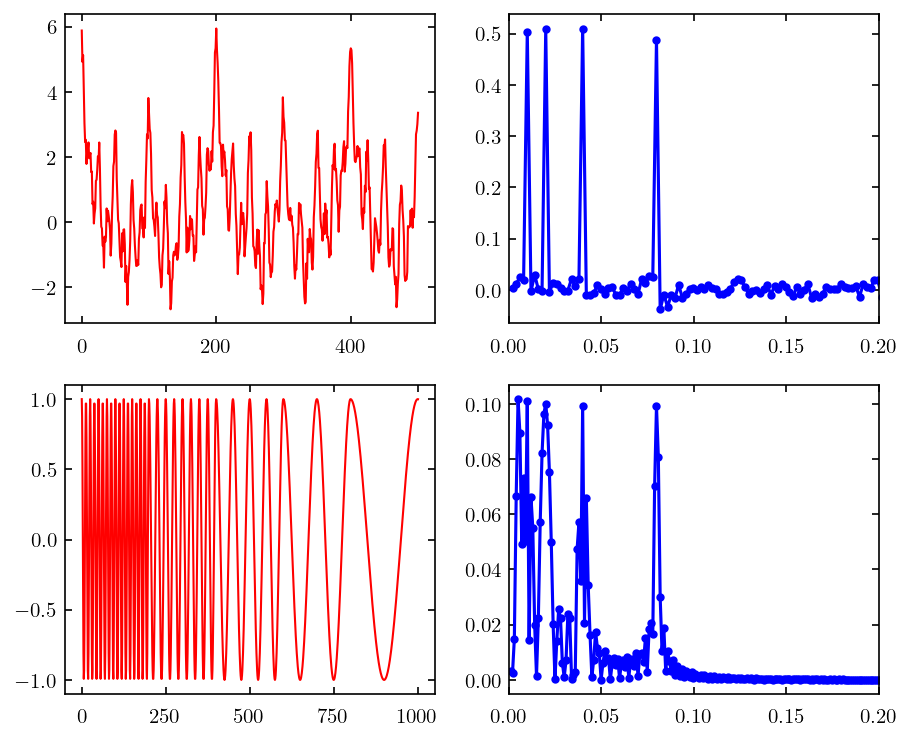

In [244]:
fig1 = plt.figure(figsize=(7,6), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4=  fig1.add_subplot(221), fig1.add_subplot(222), fig1.add_subplot(223), fig1.add_subplot(224)


x=np.arange(0.0, 500.5, 1)
T1, T2, T3, T4, T5 = 100/8, 100/4, 100/2, 100, 100*2
f1, f2, f3, f4, f5 = 1/T1, 1/T2, 1/T3, 1/T4, 1/T5
y0 = np.cos(2*np.pi*f1*x)+np.cos(2*np.pi*f2*x)+np.cos(2*np.pi*f3*x)++np.cos(2*np.pi*f4*x) \
    + np.cos(2*np.pi*f5*x) + np.random.random(x.shape)
ax1.plot(x, y0, "r-", lw=1)

N=y0.size              
y0fft = (1./N)*np.fft.fft(y0)           # Compute the one-dimensional n-point discrete Fourier Transform (DFT) of data with the efficient Fast Fourier Transform (FFT) algorithm [CT]
freq = np.fft.fftfreq(N,(x[1]-x[0]))    # Return the Discrete Fourier Transform sample frequencies
y0fft = np.fft.fftshift(y0fft.real)          # Shift the zero-frequency component to the center of the spectrum
freq = np.fft.fftshift(freq)            # Shift the zero-frequency component to the center of the spectrum


y0fft = y0fft[freq>0]
freq = freq[freq>0]

ax2.plot(freq, y0fft, "bo-", ms=3)
ax2.set_xlim(0, 0.2)


x=np.arange(0.0, 1001.1, 1)
x1 = np.arange(0.0, 200., 1)
y = np.zeros(x.shape)
y[0:200] = np.cos(2*np.pi*f1*x1)
x2 = np.arange(200., 400., 1.)

y[200:400] = np.cos(2*np.pi*f2*x2)
x3 = np.arange(400.0, 600., 1)
y[400:600] = np.cos(2*np.pi*f3*x3)
x4 = np.arange(600., 800., 1)
y[600:800] = np.cos(2*np.pi*f4*x4)
x5 = np.arange(800., 1001.5, 1)
y[800:1002] = np.cos(2*np.pi*f5*x5)

ax3.plot(x, y, "r-", lw=1)

N=y.size              
yfft = (1./N)*np.fft.fft(y)           # Compute the one-dimensional n-point discrete Fourier Transform (DFT) of data with the efficient Fast Fourier Transform (FFT) algorithm [CT]
freq = np.fft.fftfreq(N,(x[1]-x[0]))    # Return the Discrete Fourier Transform sample frequencies
yfft = np.fft.fftshift(yfft.real)          # Shift the zero-frequency component to the center of the spectrum
freq = np.fft.fftshift(freq)            # Shift the zero-frequency component to the center of the spectrum


yfft = yfft[freq>0]
freq = freq[freq>0]

ax4.plot(freq, np.abs(yfft), "bo-", ms=3)
ax4.set_xlim(0, 0.2)


In [204]:
f, t, Zxx = signal.stft(y, 0.01, nperseg=1000)
amp = 2 * np.sqrt(2)

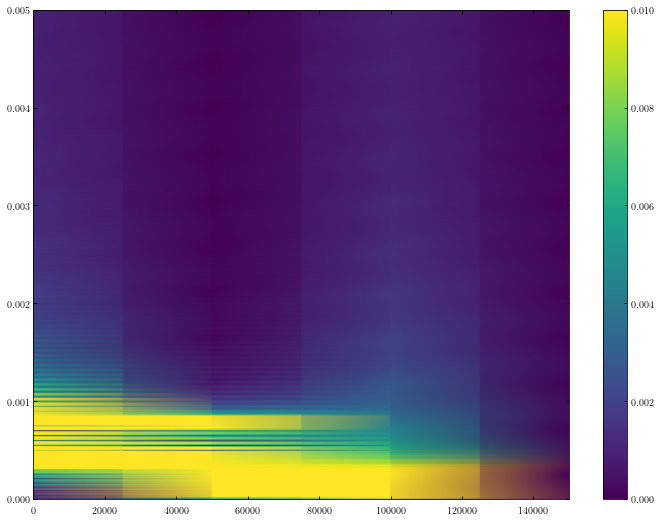

In [205]:
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=0.01, shading='gouraud')
plt.colorbar()

## 10.2. 웨이블릿 변환 (Wavelet Transform)

### STFT (Short Term Fourier Transform)

주파수 별로 쪼갠 신호의 시간에 대한 의존도를 알려고 할 때, 신호 전체를 한꺼 번에 푸리에 변환 할 것이 아니라, 신호를 작은 시간 창 (time-window)로 쪼개서 각각의 창 속에 있는 신호를 변환하는 방법.

푸리에 변환은 다음과 같이 기술된다.
$$
F(\omega)= \int_{-\infty}^{\infty} f(t) \exp (-i\omega t) \, dt
$$

이에 대해 STFT 는 윈도우 함수 (window funnction) $h(t)$ 에 대해
$$
F(\omega)= \int_{-\infty}^{\infty} f(t) h(t-\tau) \exp (-i\omega t) \, dt
$$
로 정의된다.

<br>

### Window function
윈도우 함수는  apodization function 혹은 tapering function 이라고도 불리며 어떤 특정 interval 밖에서는 0 값을 가지며, 보통 interval의 중심에 대해 대칭이고, 중심에서 최대값을 가진다. Haan window 나 Gaussian window 가 많이 쓰인다고 한다.

<br>

### STFT 에서의 시간분해능과 주파수 분해능.

- Window 함수의 너비를 짧게 잡을수록, 시간분해능은 좋아지지만, 역으로 그 안에 있는 신호의 성분 개수를 그만큼 덜 잡게 되므로, 주파수 분해능은 낮아짐
- 반대로 Window 함수의 창의 너비를 넓게 잡을수록, 시간 분해능은 떨어지지만, 그만큼 잡을 수 있는 신호의 종류가 많아지므로, 주파수 분해능은 높아짐. 
- 시간 분해능과 주파수 분해능을 동시에 높이는 것은 불가능한데, 그 이유는 근본적으로 불확정성의 원리 $\Delta \omega \cdot \Delta t \ge 1$가 작용하기 때문입니다.
- 두 분해능을 적절하게 높이면서 신호의 손실을 줄일 수 있는 방법이 바로 웨이블릿 변환.


Text(0.5, 1.0, 'f(x) h(x-$\\tau$)')

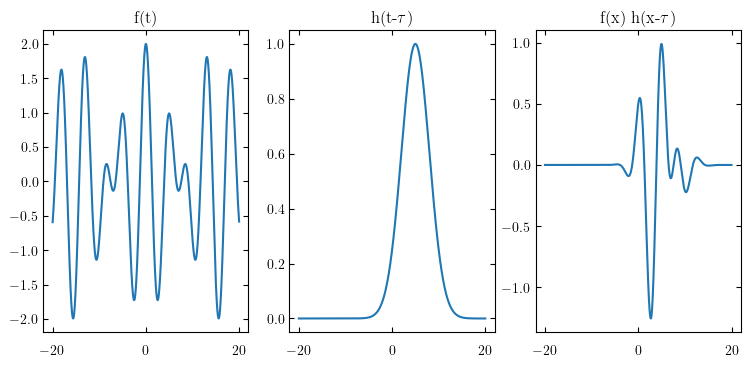

In [328]:
fig1 = plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)
x = np.arange(-20, 20, 0.01)
y = np.cos(x)+np.cos(np.sqrt(2)*x)

def fwindow(x, sig=1.0):
    f = np.exp(-x**2/2/(sig**2))
    f[x<-4*sig] = 0.
    f[x>4*sig] = 0.
    return f

def stft0(t, x, f, wf):
    return (x*f*wf*np.exp(-1.j*x*t)).sum()*0.1
    
stft = np.vectorize(stft0, excluded = ['x', 'f', 'wf'])    
    
ax1.plot(x,y)
ax1.set_title("f(t)")
ax2.plot(x, fwindow(x-5, 3.0))
ax2.set_title("h(t-$\\tau$)")
sf=stft(x, x, y, fwindow(x-5, 3.0))
ax3.plot(x, y*fwindow(x-5, 3.0))
ax3.set_title("f(x) h(x-$\\tau$)")


### 웨이블릿(wavelet) 과 웨이블린 변환

- 웨이블릿(wavelet)이란 0을 중심으로 증가와 감소를 반복하는 진폭을 수반한 파동 같은 진동을 말한다. 그것은 지진계나 심박 체크에 기록되어 보이는 것과 같은 전형적인 "짧은 진동"의 형태로 나타난다. 일반적으로 웨이블릿은 신호 처리에 유용한 특정한 성질을 가지도록 하는 목적을 가지고 만들어진다. 웨이블릿은 합성곱(convolution) 기술을 통해 알고 있는 신호와 결합하여, 알려지지 않은 신호로부터 정보를 추출하는데에 사용될 수 있다.

- 웨이블릿 함수에는 Haar function, Ingrid Dauhechies function, Biorthogonal function, Coiflets function, Symlets function, Morlet function, Mexican Hat function, Meyer function, dual-tree complex wavelet transform (DCWT) 등 여러 종류가 있다. 

- 웨이블릿 (Wavelet)이라는 이름에서도 알 수 있 는 것이지만, 웨이블릿의 뜻은 파동과 비슷한 진동체 (wave-like oscillation)를 의미하는데, <u>어떤 종류의 웨이블릿 함수든, 그 평균값은 0이며, 대부분의 웨이블릿 함수는 불규칙하고 비대칭적인 특징이 있다.</u>  

- 또한, 웨이블릿 함수값은 STFT 에서의 window function 값과 같이 어떤 interval을 제외한 부분에서는 0 이다.

- 웨이블릿 변환은 시간 분해 간격 과 주파수 분해 간격이 반드시 일정할 필요가 없다. 웨이블릿 변환은 고주파 성분 신호에 대해서는 시간 해상도를 높이고, 주파수 해상도를 낮추는 반면, 저주파 성분 신호에 대해서는 주파수 해상도를 높이고, 시간해상도를 낮춘다. 즉, 주파수 해상도와 시간 해상도 둘 다 어느 정도는 잡을 수 있다.

<br>

### 스케일 변화 (scaling) 와 위치 이동 (shifting)

- 스케일 변화(scaling)는 웨이블릿 함수의 주기를 조절한다는 뜻이다. 예를 들어 어떤 기본 웨이블릿 함수의 주기를 두 배로 늘리는 operation 은 scale factor 2인 <b>stretching </b><이라고 한다. 

- 보통 scale factor가 1 이상이면 <b>stretching</b>, 1 미만이면 <b>compressing</b>이라고 부르는데, 1 이상의 stretched scaling의 경우, high scale (or large scale) 이라고 부르며, 이를 stretched wavelet이라고 한다. 

- Stretched wavelet은 주로 변화가 느리고 뭉쳐있는 신호를 분석할 때 유용하기 때문에, 저주파 신호 분석에 적합하다. 

- 반면, scale factor가 1 미만인 경우, low scale (or small scale)이라고 부르며, 이를 compressed wavelet이라고 부르는데, 이는 주로 빠르게 변하는 신호를 분석할 때 유용하기 때문에, 고주파 신호 분석에 적합하다.

- 위치 이동 (shifting)은 시간축에 따라 기본 웨이블릿 함수 $f(t)$를 $\tau$ 만큼 평행이동 시키는 것, 즉 $f(t-\tau)$로 만드는 것을 의미한다.

- 연속 웨이블릿 함수 (mother wavelet) $\Psi (t)$의 스케일 변화와 위치 이동을 수학적으로 표현하면 다음과 같습니다.

$$
\Psi_{j,\,\tau} (t) = \dfrac{1}{\sqrt{j}} \Psi \left( \dfrac{t-\tau}{j}\right)
$$

위 방정식에서, $j$와 $\tau$ 는 각각 기본 연속 웨이블릿 함수의 스케일링과 위치 변화에 관한 지표이다.

<br>

### 웨이블릿 변환

원본 함수 $f(t)$ 에 대한 연속 웨이블릿 변환을 다음과 같이 정의한다.

$$
Y(j,\,\tau) = \int f(t) \,\Psi_{j,\,\tau}(t)\, dt
$$


웨이블릿변환에 대한 역변환도 존재한다. 연속 웨이블릿 역변환은 수학적으로는 다음과 같이 표현된다.

$$
f(t) = \dfrac{1}{C_{\Psi}}\int_0^\infty \int_{-\infty}^{\infty} W_{\Psi} (s,\, \tau) \dfrac{\Psi_{j,\,\tau} (t)}{s^2} \, d\tau\,ds,\qquad \text{where } C_{\Psi} = \int_{-\infty}^{\infty} \dfrac{|\psi (\mu)|}{|\mu|}\, d\mu
$$

여기서 $\psi(\mu)$ 는 $\Psi (t)$ 의 푸리에 변환이다.

<br>



### 이산 웨이블렛 변환 (discrete wavelet transform)

- Haar function으로 사용할 경우, 2의 지수함수 형태를 스케일 인자로 활용하 여 다음과 같이 웨이블릿 함수를 구성한다.

$$
\begin{aligned}
\Psi (t) =\Psi_{0,\,0} (t)  &=  \left\{\begin{array}{ll} 1 \qquad &\text{if }t\in [0,\,0.5) \\ -1 &\text{if } t\in [0.5,\,1)\\ 0 & \text{oterwise}\end{array} \right. \\
\Psi_{j,\,\tau} (t)&= 2^{j/2} \Psi \left(2^jt - \tau\right)
\end{aligned}
$$

<br>

### 스케일링 함수 (척도 구성 함수)

- 모든 웨이블릿 함수는 기본적으로 밴드 패스 필터 (band-pass filter) 역할을 하는데, 앞서 살펴 본 것처럼, 스케일 인자가 달라지면 (예를 들어 인자가 두 배씩 커지면) 필터링 하는 영역은 반으로 줄어든다. 원본 신호를 온전히 웨이블릿 함수만으로 표현하기 위해 서는 스케일 인자가 무한히 필요하며, 이를 우회하기 위해 각 웨이블릿 함수에는 마치 짝처럼 척도 구성 함수 (스케일링 함수) $\phi (t)$가 필요하다. 예를 들어, $\Psi_{0,0} (t)$에 대한 스케일링 함수 $\Phi_{0,\,0} (t)$는 다음과 같다.

$$
\Phi_{0,\,0}(t) = \left\{\begin{array}{ll} 1 \qquad &\text{if }t\in [0,\,1) \\ 0 &\text{otherwise} \end{array} \right.
$$


- 특정 해상도의 스케일링 함수 함수에 웨이블릿 함수를 더하면 한 단계 높은 해상도의 척도 구성 함수가 만들어질 수 있기 때문에, 특정 해상도의 웨이블릿 함수도 한 단계 높은 해상도 (즉, 스케일 팩터 2를 곱한 결과)에서 위치 이동된 척도 구성 함수로 다음과 같이 표현할 수 있다.

$$
\Psi (t)= \sum_k g(k) \Phi (2t-\tau)
$$

이 때 $g(k)$ 를 웨이블릿 함수 계수라 부른다. 이를 이용하면 원본 함수를 한단계 해상도가 높아진 단계에서 다음과 같이 표현 할 수 있다.

$$
f(t) = \sum_{k} c_{j} (k) \,\Phi (2^{j}t - \tau)
$$

이를 한 단계 낮은 해상도에서 표현해도 정보가 유지되어야 하므로, 웨이블릿 함수를 추 가해야 하며, 이를 다음과 같이 표현할 수 있다.

$$
f(t) = \sum_{k} c_{j} (k) \,\Phi (2^{j}t - \tau) + \sum_{k} d_j (k)\, \Psi (2^j-\tau)
$$

위의 표현에서 알 수 있듯, 이산 웨이블릿 변환은 척도 구성 함수 $\Phi(t)$와 웨이블릿 함수 $\Psi(t)$ 의 선형 결합으로 표현될 수 있으며, 특히, 여기서 $c_j (k)$ <b>척도 구성 계수</b>, $d_j (k)$ 는 <b>웨이블릿 계수</b> 라고 한다.

#### Haar wavelent 의 성질

- 앞서 보았듯이 Haar wavelet function 은 다음과 같이 정의된다. 

$$
\begin{aligned}
\Psi (t) =\Psi_{0,\,0} (t)  &=  \left\{\begin{array}{ll} 1 \qquad &\text{if }t\in [0,\,0.5) \\ -1 &\text{if } t\in [0.5,\,1)\\ 0 & \text{oterwise}\end{array} \right. \\
\Psi_{j,\,\tau} (t)&= 2^{j/2} \Psi \left(2^jt - \tau\right)
\end{aligned}
$$

- Haar wavelet 의 scaling funtion은 다음과 같다.

$$
\begin{aligned}
\Phi (t) =\Phi_{0,\,0} (t)  &=  \left\{\begin{array}{ll} 1 \qquad &\text{if }t\in [0,\,1) \\  0 & \text{oterwise}\end{array} \right. \\
\Phi_{j,\,\tau} (t)&= \Phi \left(2^jt - \tau\right)
\end{aligned}
$$
- 스케일 인자와 haar wave function $\Psi (t)$ 및 scale function $\Phi(t)$ 사이에는 다음과 같은 관계가 성립한다.

$$ 
\begin{aligned}
\Phi (t) &= \Phi (2t) + \Phi (2t-1) \\
\Psi (t) &= \Psi (2t) - \Psi (2t-1)
\end{aligned}
$$


- 수학적으로 힐버트 공간 $\mathbb{R}$ 에서 $\Psi_{j,\, \tau} $ 는 다음과 같은 <b>직교성 (ortoginality)</b> 을 갖는다

$$
\int_{\mathbb{R}} \Psi_{j_1,\,\tau_1} (t) \, \Psi_{j_2,\, \tau_2} (t) \, dt = \int_{\mathbb{R}} 2^{(j_1+j_2)/2} \, \Psi (2^{j_1}t-\tau_1) \,\Psi (2^{j_2}t-\tau_2)\, dt = \delta_{j_1,\,j_1} \,\delta_{\tau_1,\,\tau_2}
$$

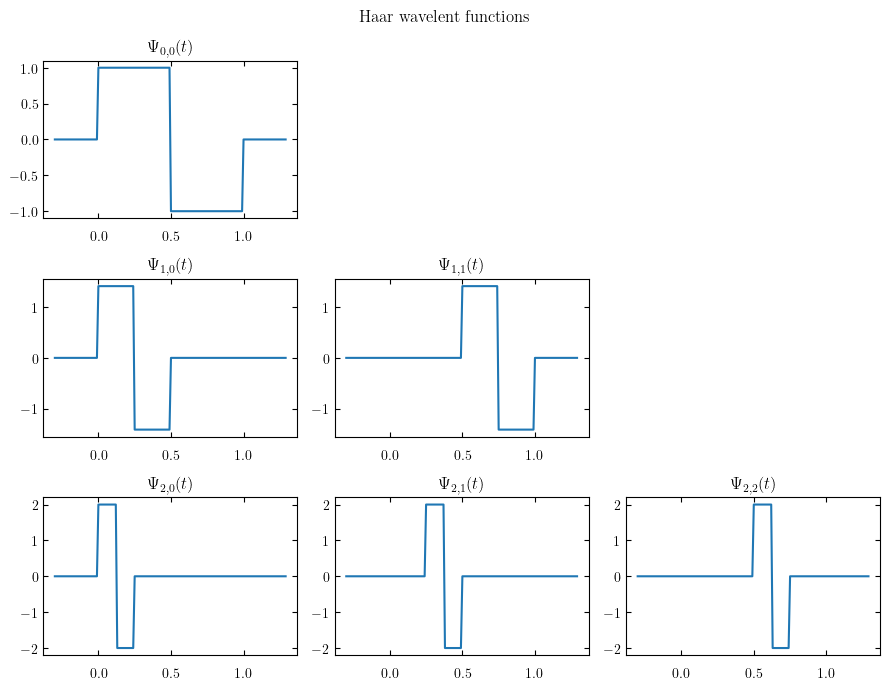

In [378]:
def haar0(x):
    """
    Harr wavelet's mother wavelet function
    """
    if x < 0.:
        return 0.
    elif x<0.5 :
        return 1.
    elif x<1. :
        return -1.
    else :
        return 0.
    
def haar_nk(n, k, x):
    return 2**(n/2) * harr0 ((2**n)*x -k)

haar = np.vectorize(haar_nk, excluded =["n", "k"])

fig1 = plt.figure(figsize=(9,7), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig1.add_subplot(331), fig1.add_subplot(334), fig1.add_subplot(335)
ax4, ax5, ax6 = fig1.add_subplot(337), fig1.add_subplot(338), fig1.add_subplot(339)
x = np.arange(-0.3, 1.3, 0.01)
ax1.plot(x, harr(0, 0, x))
ax1.set_title("$\\Psi_{0,0}(t)$")

ax2.plot(x, haar(1, 0, x))
ax2.set_title("$\Psi_{1,0}(t)$")

ax3.plot(x, haar(1, 1, x))
ax3.set_title("$\Psi_{1,1}(t)$")

ax4.plot(x, haar(2,0, x))
ax4.set_title("$\Psi_{2,0}(t)$")

ax5.plot(x, haar(2,1, x))
ax5.set_title("$\Psi_{2,1}(t)$")

ax6.plot(x, haar(2,2, x))
ax6.set_title("$\Psi_{2,2}(t)$")

fig1.suptitle("Haar wavelent functions")
fig1.tight_layout()
plt.show()

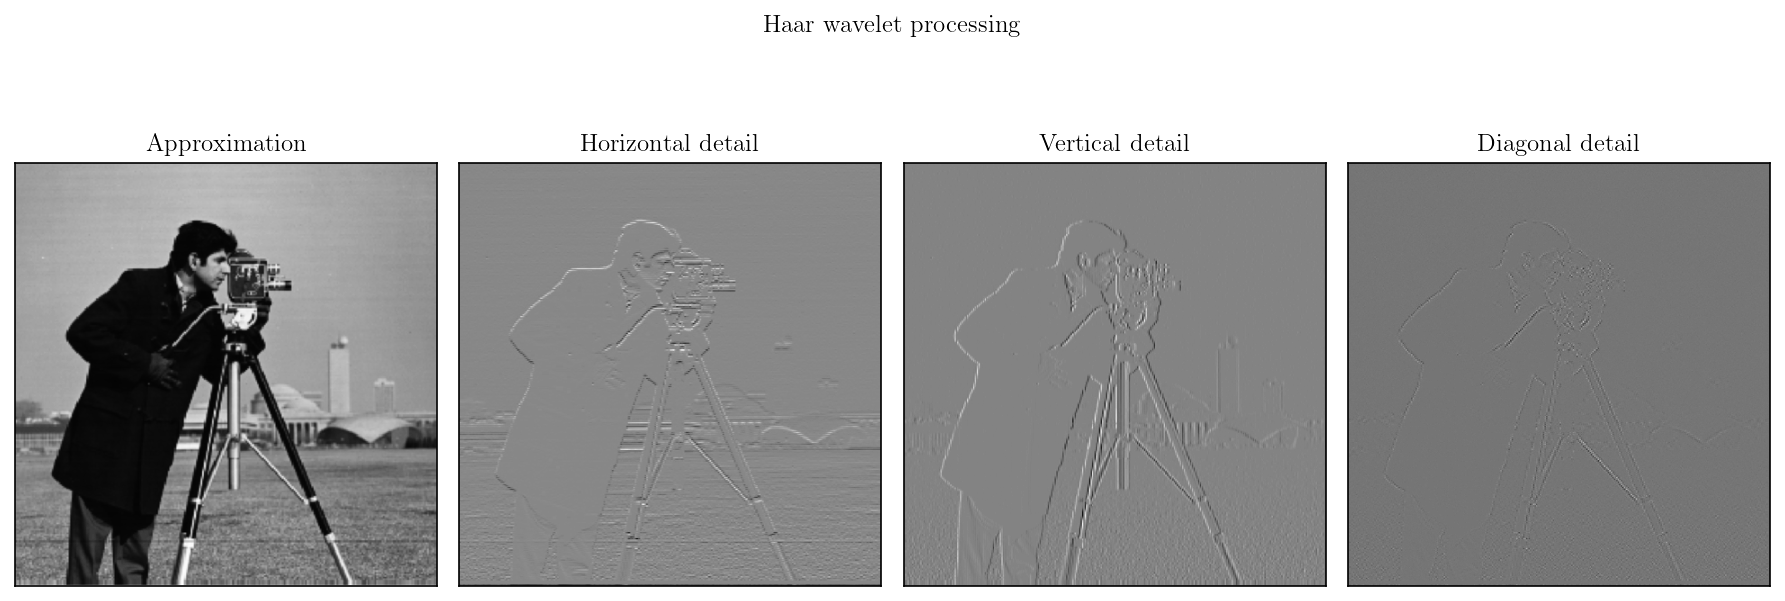

In [389]:
img_cameraman=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)

# code from https://pywavelets.readthedocs.io/en/latest/
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

# pywt.dwt2 : 2D wavelet transform
# cA, (cH, cV, cD) : coefficients - Approximation, (horizontal detail, vertical detail and diagonal detail) 
cA, (cH, cV, cD)  = pywt.dwt2(img_cameraman, 'haar')

fig = plt.figure(figsize=(12,5), dpi= 150, facecolor='w', edgecolor='k')
for i, a in enumerate([cA, cH, cV, cD]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, cmap='gray')
    ax.set_title(titles[i], fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.suptitle("Haar wavelet processing")
plt.show()

In [412]:
cH.max(), cH.min()

(86.50000000000003, -98.00000000000001)

In [390]:
# List of wavelets supported by pywavelet (pywt)
for family in pywt.families():
    print("%s family: " % family + ', '.join(pywt.wavelist(family)))    

haar family: haar
db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
sym family: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
coif family: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
bior family: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
rbio family: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
dmey family: dmey
gaus family: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
mexh family: mexh
morl family: morl
cgau family: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, 

### Wavelet 변환을 이용한 노이즈 처리.

- 이미지 픽셀값이 아닌 웨이블릿 계수값을 기준으로 노이즈를 처리.
- 대부분의 이미지 웨이블릿 변환 결과에서 나오는 계수값 행렬은 굉장히 sparse 하므로 (전체 행렬에서 0 이 차지 하는 비중이 매우 높으므로), 이들 계수값을 기준으로 노이즈 처리하는 것이 효과적인 경우가 많음. 
- 노이즈 처리에 활용되는 웨이블릿 함수로서 biorthogonal wavelet이 많이 쓰임. 
- 특정 문턱값을 기준으로 계수값 행렬을 처리한 후, 다시 그 결과물을 역 웨이블릿 변환하면 노이즈가 처리되는 방식으로 웨이블릿 변환이 노이즈 처리에 활용함.
- 웨이블릿 변환에서 문턱값을 설정하여 세부값의 웨이블릿 계수를 처리하는 방식에는 크게 두 가지 종류가 있음:  <b>Soft thresholding</b>, <b>hard thresholding </b>.


#### Soft thresholding and Hard thresholding

- Hard thresholding 함수는 다음과 같다.

$$
D(d|\lambda) = \left\{\begin{array}{ll} 0 \qquad & \text{for }|d|\le \lambda \\ d & \text{for } |d|>\lambda \end{array} \right.
$$

- Soft thresholding 함수는 다음과 같다.

$$
D(d|\lambda) = \left\{\begin{array}{ll} 0 \qquad & \text{for }|d|\le \lambda \\ d-\lambda & \text{for } d>\lambda \\ d+\lambda & \text{for } d<-\lambda \end{array} \right.
$$

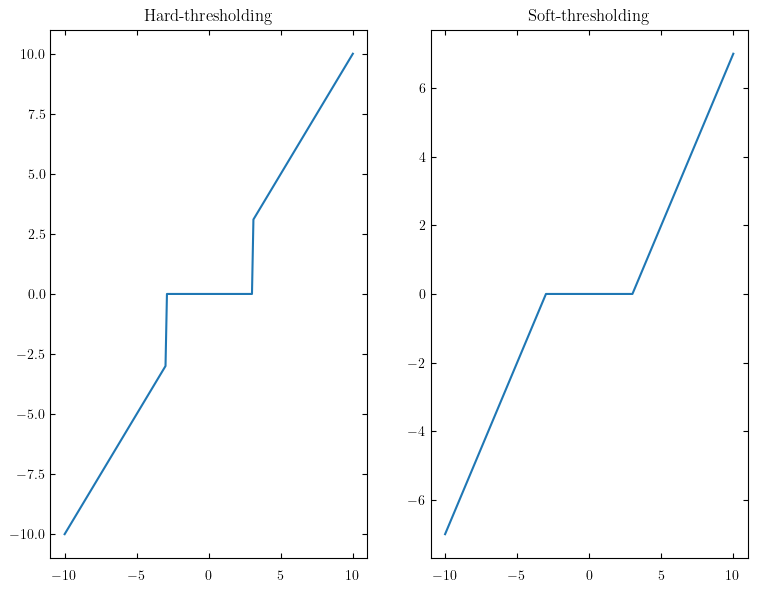

In [403]:
def soft_thresholding0(x, lmd):
    if np.abs(x) <= lmd:
        return 0
    else :
        return x

def hard_thresholding0(x, lmd):
    if x>lmd :
        return x-lmd
    elif x<-lmd :
        return x+lmd
    else :
        return 0

soft_thresholding = np.vectorize(soft_thresholding0, excluded=["lmd"])
hard_thresholding = np.vectorize(hard_thresholding0, excluded=["lmd"])

fig1 = plt.figure(figsize=(9,7), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2 = fig1.add_subplot(121), fig1.add_subplot(122)

x = np.arange(-10, 10.1, 0.1)
ax1.plot(x, soft_thresholding(x, 3.))
ax1.set_title("Hard-thresholding")
ax2.plot(x, hard_thresholding(x, 3.))
ax2.set_title("Soft-thresholding")
fig.tight_layout()


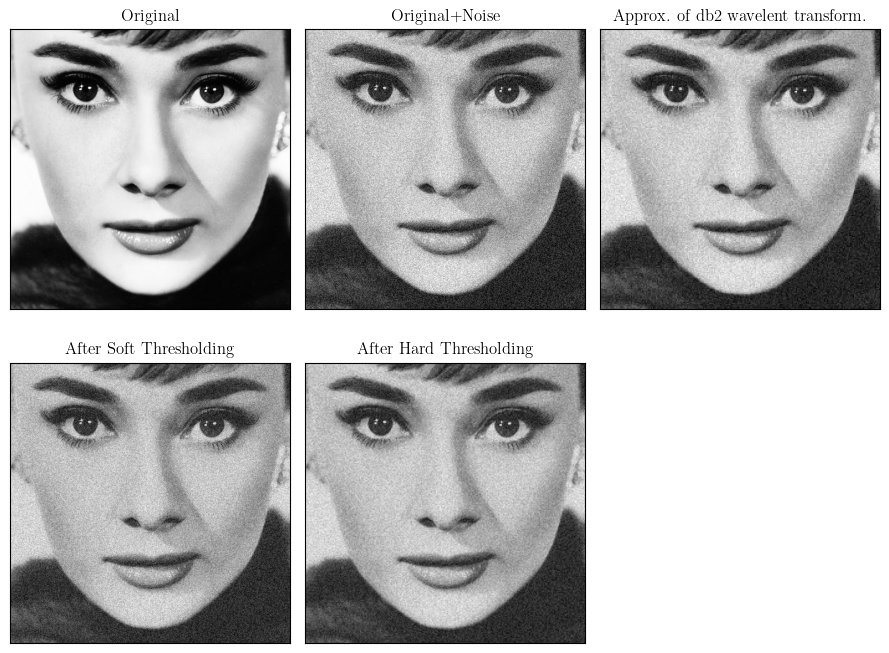

In [545]:
img_audri = cv2.cvtColor(cv2.imread("./img_audreyhepburn.png"), cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(9,7), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
ax4, ax5 = fig.add_subplot(234), fig.add_subplot(235)
ax1.imshow(img_audri, cmap='gray')
ax1.set_title("Original")
img1 = img_audri + np.random.random(img_audri.shape)*100.

ax2.imshow(img1, cmap='gray')
ax2.set_title("Original+Noise")

cA, (cH, cV, cD)  = pywt.dwt2(img1, 'db2')


pp = 0.6746
ax3.imshow(cA, cmap='gray')
ax3.set_title("Approx. of db2 wavelent transform.")
v1 = np.median(np.abs(cH))
cH1 = soft_thresholding(cH,v1/pp) 

v2 = np.median(np.abs(cV))
cV1 = soft_thresholding(cV, v2/pp)

v3 = np.median(np.abs(cD))
cD1 = soft_thresholding(cD, v3/pp)

img2 = pywt.idwt2((cA, (cH1, cV1, cD1)),'db2') 

ax4.imshow(img2, cmap='gray')
ax4.set_title("After Soft Thresholding")

w1 = np.median(np.abs(cH))
cH2 = hard_thresholding(cH, w1/pp) 

w2 = np.median(np.abs(cV))
cV2 = hard_thresholding(cV, w2/pp)

w3 = np.median(np.abs(cD))
cD2 = hard_thresholding(cD, w3/pp)

img3 = pywt.idwt2((cA, (cH2, cV2, cD2)),'db2') 
ax5.imshow(img3, cmap='gray')
ax5.set_title("After Hard Thresholding")

for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

## 10.3. 가보 변환 (Gabor Transform or Gabor filtering)

### Gabor Transformation
- 웨이블릿 변환으로 이미지 피사체의 경계 정보를 추출하는 데에도 이용 할 수 있지만, 사실 웨이블릿 변환만 가지고는 피사체 경계의 방향까지 정확히 검지해 내는 것은 굉장히 어려우며,  
- 이를 보강할 수 있는 방법 중 하나가 바로 가보 필터링 (Gabor filtering) 혹은 가보 변환 (Gabor transform)을 하는 것임.

#### Gabor Filter and Garor Filter Kernel

- 사인화된 가우시안 곡선

$$
g(x,\,y,\,\lambda,\,\theta,\, \psi,\, \sigma,\,\gamma ) = \exp \left(-\dfrac{x'^2+\gamma^2 y'^2}{2\sigma^2}\right)  \cos \left(2 pi \dfrac{x'}{\lambda} + \psi \right)\\
x' = x \cos \theta + y \sin \theta ,\qquad y' = -x \cos \theta + y \sin \theta
$$


- $\lambda$ 는 가보 필터의 사인 함수 조절 인자로 작용합니다. 가보 필터는 중심으로부터 주변 값을 더하거나 빼는 과정을 거 치는데,이때 $\lambda$ 가더하고 빼는 주기를 결정합니다.
- $\theta$ 는 가보 필터 커널의 방향성을 결정합니다. 즉, $\theta$ 가 결정짓는 것은 바로 이미지 피사체 경계 정보들의 배열 방향이 됩니다. 이 파라미터 때문에 픽셀 배열의 orientation 추출이 가능해지는 것입니다. 
- $\psi$ 는 중심으로부터 가보 필터가 얼마나 평행 이동하는지를 결정하는데, 일종의 위상 조절 인자로 해석할 수 있습니다. 
- $\sigma$ 는 전형적인 가우시안 분포의 표준 편차값에 해당하는 인자로서, 가보 필터 커널의 너비를 결정하는 요소입니다. 
- $\gamma$ 는 가보 필터의 가로-세로 비율 (aspect ratio)를 결정하는 요소인데, 특수한 경우를 제외하고는 대부분의 경우 1로 설정합니다



In [541]:
def gabor_filter(x, y, lmbd=1, theta=0., psi=0., sigma=1., gamma=1.):
    x1 = x*np.cos(theta) + y * np.sin(theta)
    y1 = -x*np.sin(theta) + y * np.cos(theta)
    r = np.exp((-x1**2-(gamma**2)*(y1**2))/(2*(sigma**2))) * np.cos(2*np.pi*x1/lmbd + psi)
    return r



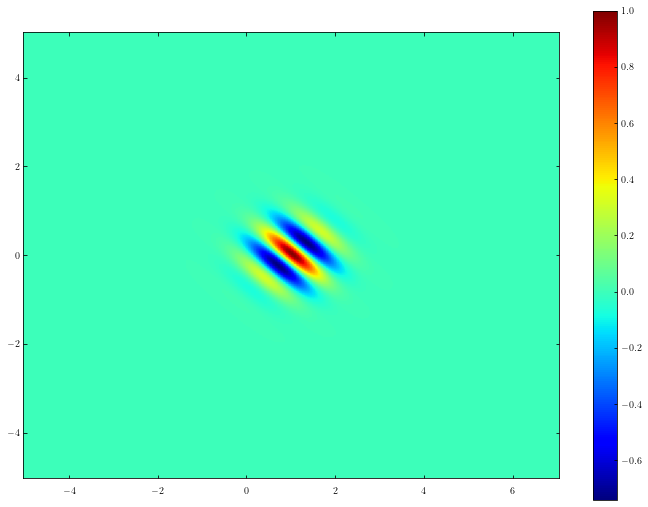

In [540]:
xmin, xmax, dx = -5, 5, 0.05
ymin, ymax, dy = -5, 5, 0.05
X, Y = np.meshgrid(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy))
img = gabor_filter(X, Y, sigma=0.5, gamma=1., lmbd = np.pi/4., theta = np.pi/4.)
plt.imshow(img, origin="lower", cmap='jet', extent=[xmin-dx/2, xmax+dx+2, ymin-dy/2, ymax+dy/2])
plt.colorbar()

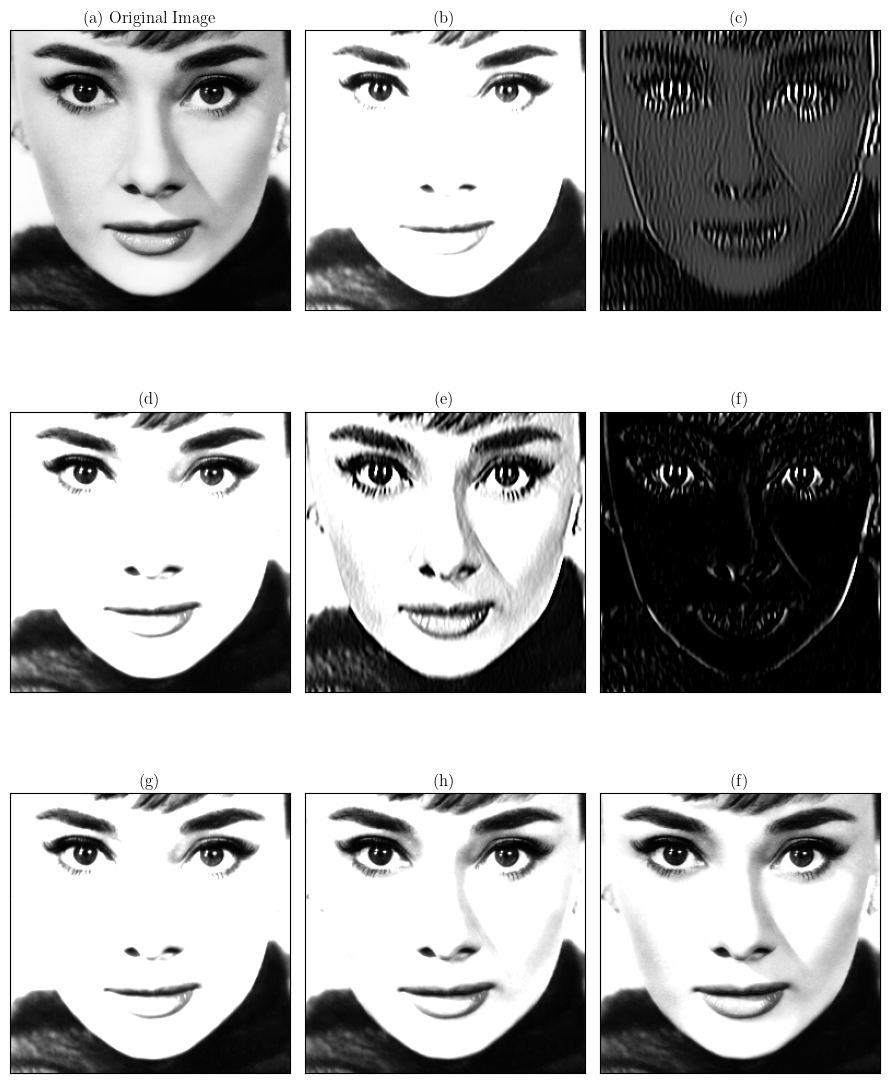

In [745]:
def get_gabor_image(img, kernelshape=(11,11), sigma=3.0, theta=0., lambd= 8, gamma=0.5, psi=0, ktype=cv2.CV_32F):
    
    # Gabor kernel
    # getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype) 
    g_kernel = cv2.getGaborKernel(kernelshape,  sigma, theta, lambd, gamma, psi, ktype)
    return cv2.filter2D(img, cv2.CV_8UC3, g_kernel)

img_audri0 = cv2.cvtColor(cv2.imread("./img_audreyhepburn.png"), cv2.COLOR_BGR2GRAY)
img_audri = cv2.resize(img_audri0, dsize=(256, 256), interpolation=cv2.INTER_AREA)

fig = plt.figure(figsize=(9,12), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig.add_subplot(331), fig.add_subplot(332), fig.add_subplot(333)
ax4, ax5, ax6 = fig.add_subplot(334), fig.add_subplot(335), fig.add_subplot(336)
ax7, ax8, ax9 = fig.add_subplot(337), fig.add_subplot(338), fig.add_subplot(339)

img2 = get_gabor_image(img_audri, kernelshape=(7,7), sigma=1.0, theta=0., lambd= 5, gamma=1., psi=0, \
                       ktype=cv2.CV_32F)
ax1.imshow(img_audri, cmap='gray')
ax1.set_title("(a) Original Image")
ax2.imshow(img2, cmap='gray')
ax2.set_title("(b)")

img3 = get_gabor_image(img_audri, kernelshape=(15,15), sigma=3.0, theta=0., lambd= 5., gamma=1., psi=0, \
                       ktype=cv2.CV_32F)
ax3.imshow(img3, cmap='gray')
ax3.set_title("(c)")


img4 = get_gabor_image(img_audri, kernelshape=(7,7), sigma=1.0/np.sqrt(2), theta=0., lambd= 5, gamma=1., psi=0, \
                       ktype=cv2.CV_32F)
ax4.imshow(img4, cmap='gray')
ax4.set_title("(d)")

img5 = get_gabor_image(img_audri, kernelshape=(7,7), sigma=2.5/np.sqrt(2), theta=0., lambd= 5, gamma=1., psi=0, \
                       ktype=cv2.CV_32F)
ax5.imshow(img5, cmap='gray')
ax5.set_title("(e)")


img6 = get_gabor_image(img_audri, kernelshape=(7,7), sigma=2.9/np.sqrt(2), theta=0., lambd= 5, gamma=1., psi=0, \
                       ktype=cv2.CV_32F)
ax6.imshow(img6, cmap='gray')
ax6.set_title("(f)")



img7 = get_gabor_image(img_audri, kernelshape=(7,7), sigma=1.0/np.sqrt(2), theta= 0., lambd= 5, gamma=1., psi=0, \
                       ktype=cv2.CV_32F)
ax7.imshow(img7, cmap='gray')
ax7.set_title("(g)")

img8 = get_gabor_image(img_audri, kernelshape=(7,7), sigma=1./np.sqrt(2), theta=0., lambd= 5, gamma=1.5, psi=0, \
                       ktype=cv2.CV_32F)
ax8.imshow(img8, cmap='gray')
ax8.set_title("(h)")


img9 = get_gabor_image(img_audri, kernelshape=(7,7), sigma=1./np.sqrt(2), theta=0., lambd= 5, gamma=3., psi=0, \
                       ktype=cv2.CV_32F)
ax9.imshow(img9, cmap='gray')
ax9.set_title("(f)")




for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

(a) Original Image

(b) kernelshape=(7,7), sigma=1.0, theta=0., lambd= 5, gamma=1., psi=0

(c) kernelshape=(15,15), sigma=3.0, theta=0., lambd= 5., gamma=1., psi=0

(d) kernelshape=(7,7), sigma=1.0/np.sqrt(2), theta=0., lambd= 5, gamma=1., psi=0

(e) kernelshape=(7,7), sigma=2.5/np.sqrt(2), theta=0., lambd= 5, gamma=1., psi=0

(f) kernelshape=(7,7), sigma=2.9/np.sqrt(2), theta=0., lambd= 5, gamma=1., psi=0

(g) kernelshape=(7,7), sigma=1.0/np.sqrt(2), theta= 0., lambd= 5, gamma=1., psi=0

(h) kernelshape=(7,7), sigma=1./np.sqrt(2), theta=0., lambd= 5, gamma=1.5, psi=0

(i) kernelshape=(7,7), sigma=1./np.sqrt(2), theta=0., lambd= 5, gamma=3., psi=0


# 10.4. 이미지 품질 측정

### 최대 신호 대 잡음비 (peak signal-to-noise ratio, PSNR)

<br>

#### PSNR
원본 이미지 $I$ 와 변환 후 이미지 $K$ 에 대해 PSNR 은 다음과 같이 정의되며 단위는 dB (데시벨) 이다.
$$
\operatorname{PSNR} = 10 \log_{10} \left[\dfrac{\operatorname{Max}(I)^2}{\text{MSE}}\right],\qquad \text{MSE} = \dfrac{1}{MN} \sum_{i=1}^M\sum_{j=1}^N { \big( } I(i,\,j) - K(i,\, j) { \big) }^2
$$

- 노이즈 타입이 salt-and-pepper 형태라면, 노이즈 정도에 따라 이미지의 PSNR값이 크게 변하는데 반해, 노이즈 타입이 Gaussian 형태라면, 노이즈 정도가 많이 변해도 PSNR값 자체는 크게 변하지 않는다.  
- PSNR만으로는 압축으로 인한 정보 손실과 블러링 등으로 인한 이미지 품질 저하를 구분하기는 어렵다.


In [856]:
from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error

def psnr(oimg, img):
    imax = np.max(oimg.astype(np.float64))
    mse = np.mean((oimg.astype(np.float64)-img.astype(np.float64))**2)
    
    if mse == 0.:
        return np.inf
    else :
        return 10.*np.log10((imax**2)/mse)

def ssim(img1, img2):
    mssim = structural_similarity(img1, img2)
    return mssim


def add_snp(img, Nsp):
    
    x = np.random.randint(0, img_cameraman.shape[0], Nsp)
    y = np.random.randint(0, img_cameraman.shape[1], Nsp)
    x1, y1 = x[::2], y[::2]
    x2, y2 = x[1::2], y[1::2]
    
    img_sp = np.array(img_cameraman, copy=True)

    for i, j in zip(x1, y1):
        img_sp[i,j]=0

    for i, j in zip(x2, y2):
        img_sp[i, j]=255

    return img_sp.astype(np.uint8)

def add_gaussian(img, sigma=1.):
    img_gau = img+np.random.normal(0., sigma, img.shape)
    img_gau[img_gau>255]=255
    img_gau[img_gau<0]=0
    return img_gau.astype(np.uint8)



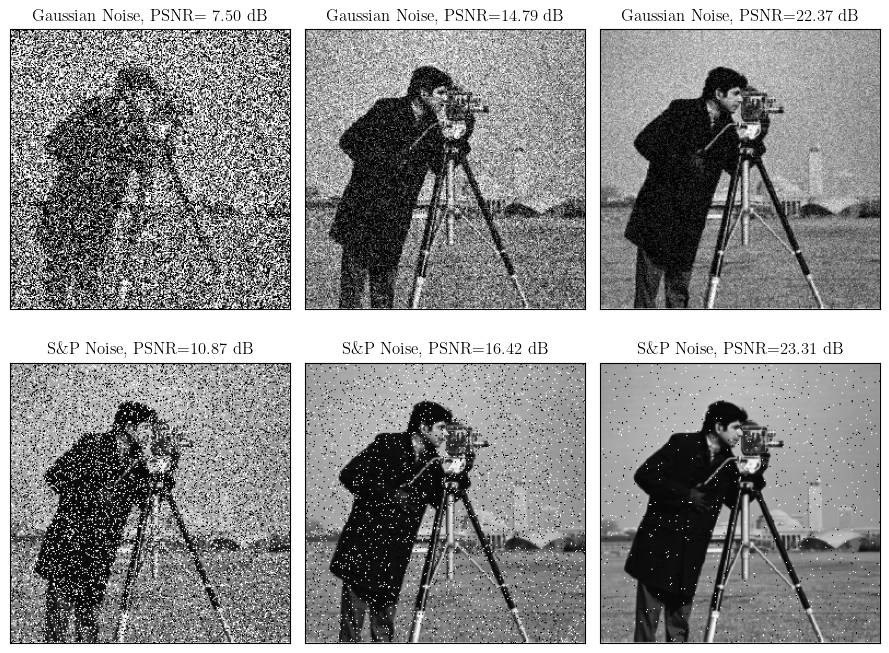

In [857]:
img_cameraman0=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)
img_cameraman = cv2.resize(img_cameraman0, dsize=(256, 256), interpolation=cv2.INTER_AREA)


fig = plt.figure(figsize=(9,7), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
ax4, ax5, ax6 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)


img_gau1 = add_gaussian(img_cameraman, 200.0)
psnr1 = psnr (img_cameraman, img_gau1)
ax1.imshow(img_gau1, cmap='gray')
ax1.set_title("Gaussian Noise, PSNR=%5.2f dB"%(psnr1))

img_gau2 = add_gaussian(img_cameraman, 50.0)
psnr2 = psnr (img_cameraman, img_gau2)
ax2.imshow(img_gau2, cmap='gray')
ax2.set_title("Gaussian Noise, PSNR=%5.2f dB"%(psnr2))

img_gau3 = add_gaussian(img_cameraman, 20.0)
psnr3 = psnr (img_cameraman, img_gau3)
ax3.imshow(img_gau3, cmap='gray')
ax3.set_title("Gaussian Noise, PSNR=%5.2f dB"%(psnr3))

img_sp4 = add_snp(img_cameraman, 20_000)
psnr4 = psnr (img_cameraman, img_sp4)
ax4.imshow(img_sp4, cmap='gray')
ax4.set_title("S\&P Noise, PSNR=%5.2f dB"%(psnr4))  

img_sp5 = add_snp(img_cameraman, 5_000)
psnr5 = psnr (img_cameraman, img_sp5)
ax5.imshow(img_sp5, cmap='gray')
ax5.set_title("S\&P Noise, PSNR=%5.2f dB"%(psnr5))  

img_sp6 = add_snp(img_cameraman, 1_000)
psnr6 = psnr (img_cameraman, img_sp6)
ax6.imshow(img_sp6, cmap='gray')
ax6.set_title("S\&P Noise, PSNR=%5.2f dB"%(psnr6))  


for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

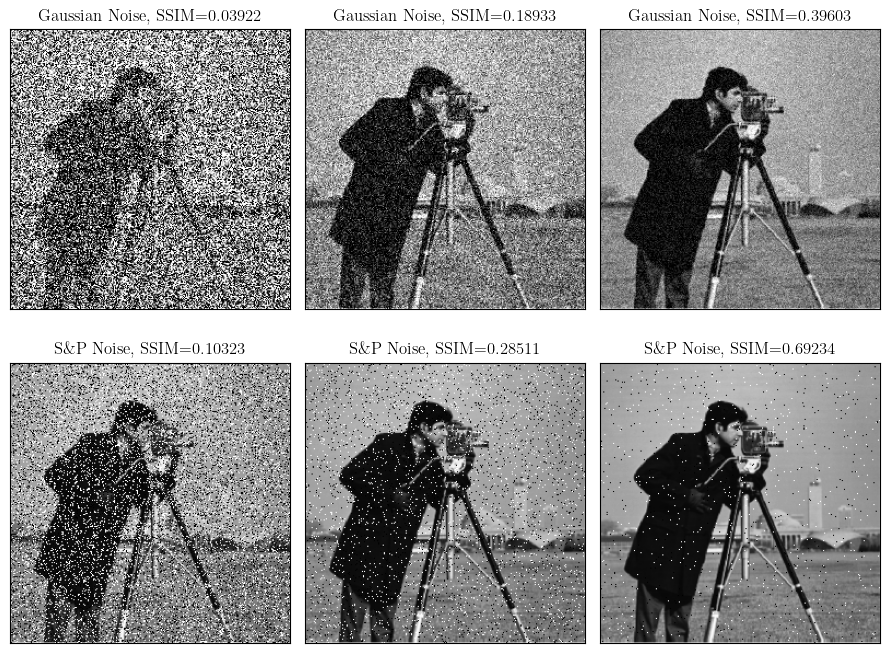

In [859]:
img_cameraman0=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)
img_cameraman = cv2.resize(img_cameraman0, dsize=(256, 256), interpolation=cv2.INTER_AREA)


fig = plt.figure(figsize=(9,7), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
ax4, ax5, ax6 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)


img_gau1 = add_gaussian(img_cameraman, 200.0)
ssim1 = ssim (img_cameraman, img_gau1)
ax1.imshow(img_gau1, cmap='gray')
ax1.set_title("Gaussian Noise, SSIM=%7.5f"%(ssim1))

img_gau2 = add_gaussian(img_cameraman, 50.0)
ssim2 = ssim (img_cameraman, img_gau2)
ax2.imshow(img_gau2, cmap='gray')
ax2.set_title("Gaussian Noise, SSIM=%7.5f"%(ssim2))

img_gau3 = add_gaussian(img_cameraman, 20.0)
ssim3 = ssim (img_cameraman, img_gau3)
ax3.imshow(img_gau3, cmap='gray')
ax3.set_title("Gaussian Noise, SSIM=%7.5f"%(ssim3))

img_sp4 = add_snp(img_cameraman, 20_000)
ssim4 = ssim (img_cameraman, img_sp4)
ax4.imshow(img_sp4, cmap='gray')
ax4.set_title("S\&P Noise, SSIM=%7.5f"%(ssim4))  

img_sp5 = add_snp(img_cameraman, 5_000)
ssim5 = ssim (img_cameraman, img_sp5)
ax5.imshow(img_sp5, cmap='gray')
ax5.set_title("S\&P Noise, SSIM=%7.5f"%(ssim5))  

img_sp6 = add_snp(img_cameraman, 1_000)
ssim6 = ssim (img_cameraman, img_sp6)
ax6.imshow(img_sp6, cmap='gray')
ax6.set_title("S\&P Noise, SSIM=%7.5f"%(ssim6))  


for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

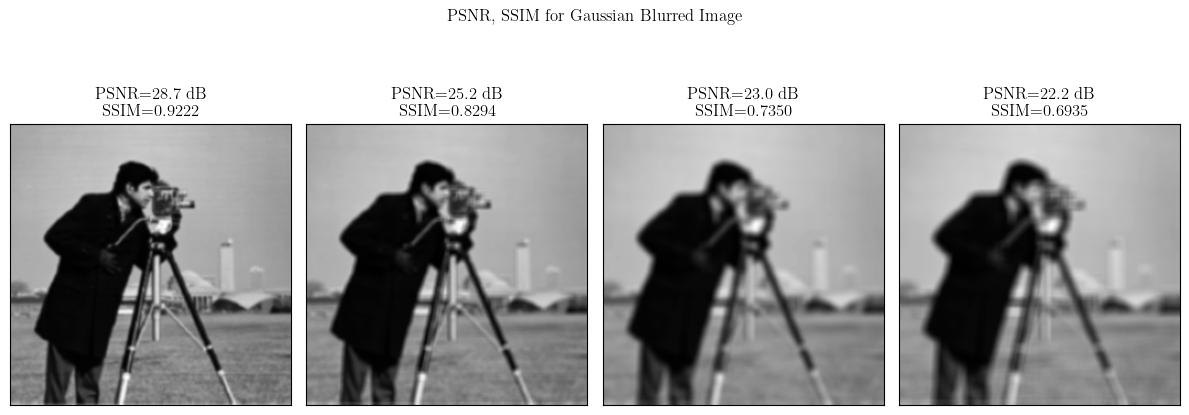

In [882]:
img_cameraman0=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)
img_cameraman = cv2.resize(img_cameraman0, dsize=(256, 256), interpolation=cv2.INTER_AREA)


fig = plt.figure(figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4 = fig.add_subplot(141), fig.add_subplot(142), fig.add_subplot(143), fig.add_subplot(144) 

img1 = cv2.GaussianBlur(img_cameraman, (5, 5), 1)
ax1.imshow(img1, cmap='gray')
psnr1 = psnr(img_cameraman, img1)
ssim1 = ssim(img_cameraman, img1)
ax1.set_title("PSNR=%4.1f dB\nSSIM=%6.4f"%(psnr1, ssim1))


img2 = cv2.GaussianBlur(img_cameraman, (5, 5), 3)
ax2.imshow(img2, cmap='gray')
psnr2 = psnr(img_cameraman, img2)
ssim2 = ssim(img_cameraman, img2)
ax2.set_title("PSNR=%4.1f dB\nSSIM=%6.4f"%(psnr2, ssim2))

img3 = cv2.GaussianBlur(img_cameraman, (9, 9), 3)
ax3.imshow(img3, cmap='gray')
psnr3 = psnr(img_cameraman, img3)
ssim3 = ssim(img_cameraman, img3)
ax3.set_title("PSNR=%4.1f dB\nSSIM=%6.4f"%(psnr3, ssim3))

img4 = cv2.GaussianBlur(img_cameraman, (9, 9), 6)
ax4.imshow(img4, cmap='gray')
psnr4 = psnr(img_cameraman, img4)
ssim4 = ssim(img_cameraman, img4)
ax4.set_title("PSNR=%4.1f dB\nSSIM=%6.4f"%(psnr4, ssim4))



for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("PSNR, SSIM for Gaussian Blurred Image")
fig.tight_layout()
plt.show()

